# Sprint 11 / Linear Algebra, by Deborah Thomas

# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [248]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.preprocessing import MaxAbsScaler

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression

from sklearn.neighbors import NearestNeighbors 
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.datasets import make_regression

from IPython.display import display
from PIL import Image

import plotly.express as px
import streamlit as st

import warnings


## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [251]:
try:
    df = pd.read_csv('/datasets/insurance_us.csv')  # Attempt to read from the server path
except FileNotFoundError:
    df = pd.read_csv('../datasets/insurance_us.csv')  # Fallback to the local path

In [252]:
df.shape

(5000, 5)

- rename columns

In [254]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [255]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1159,1,18.0,49600.0,1,0
2928,1,36.0,53600.0,2,0
987,0,26.0,41000.0,0,0
3247,1,26.0,36600.0,2,0
4454,1,32.0,20100.0,1,0
1771,1,38.0,20900.0,2,0
3938,1,23.0,32200.0,1,0
1035,1,32.0,43500.0,1,0
4839,0,24.0,35700.0,1,0
3656,0,32.0,42200.0,0,0


In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


- check datatypes

In [258]:
df['age'] = df['age'].astype('int64')

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [260]:
# now have a look at the data's descriptive statistics. 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
age,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
income,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
family_members,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
insurance_benefits,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


Quick look.
<br>
- Max age is 65. Min age is 18. Avg age is 31.
- Max salary is `$79,000`. Min salary is `$5,300`. Avg salary is '$39,916'.
- Max family members is 6. Min family members is 0. Avg family members is 1.
- Max insurance benefits is 5. Min insurance benefits is 0. Avg insurance benefits is 0.14. (0 = no claims / 5 = 5 claims)

In [262]:
df_NaN = df.isna().sum()
print(df_NaN)

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64


- Correlations between features

In [264]:
df.corr()

,gender,age,income,family_members,insurance_benefits
gender,1.000000,0.002074,0.014910,-0.008991,0.010140
age,0.002074,1.000000,-0.019093,-0.006692,0.651030
income,0.014910,-0.019093,1.000000,-0.030296,-0.014963
family_members,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
insurance_benefits,0.010140,0.651030,-0.014963,-0.036290,1.000000


- Correlation coefficients range between -1 and 1.
- A coefficient close to 1 implies a strong positive linear relationship.
- A coefficient close to -1 implies a strong negative linear relationship.
- A coefficient around 0 implies little to no linear relationship.

There is a fairly strong positive correlation between age and insurance benefits. The other features do not correlate.

- check for null values

In [268]:
df.isnull().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

There are no null values.

- check for duplicates

In [271]:
df.duplicated().sum()

153

In [272]:
# Drop duplicate rows in place
df.drop_duplicates(inplace=True)

print(df.shape)

(4847, 5)


Data is clean now. There are now 4847 rows, after dropping duplicates.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

In [276]:
# Replace inf and -inf values with NaN
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

In [277]:
# Drop rows with NaN values (this will remove any rows that may have been created due to replacing inf)
df.dropna(inplace=True)

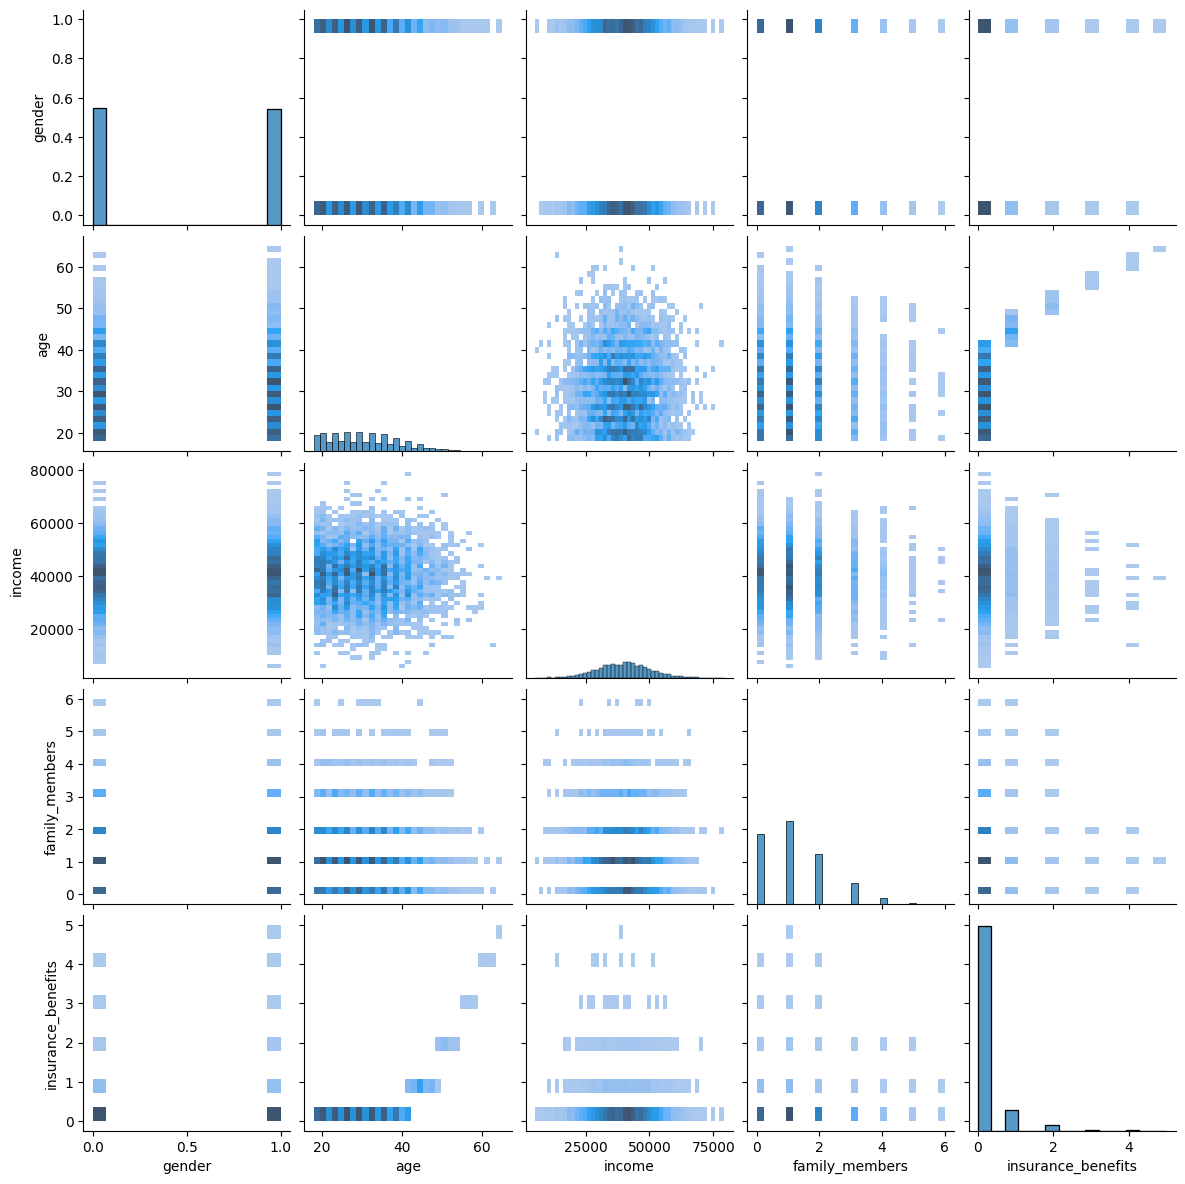

In [278]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

- age

In [280]:
# Define the font size for titles and axis labels
title_font_size = 24
axis_label_font_size = 18

# Group data to find the average salary per age
age_salary_summary = df.groupby('age').income.mean().reset_index()

In [281]:
# Create a bar graph: Average Salary per Age
fig_bar = px.bar(
    age_salary_summary,
    x='age',
    y='income',
    title='Average Salary per Age',
    labels={'income': 'Average Salary ($)', 'age': 'Age'}
)
fig_bar.update_layout(
    title_font=dict(size=title_font_size), title_x=0.5,
    xaxis_title_font=dict(size=axis_label_font_size),
    yaxis_title_font=dict(size=axis_label_font_size)
)
st.plotly_chart(fig_bar)

DeltaGenerator()

In [282]:
# Create three box plots
fig_salary_box = px.box(df, y="income", title="Salary Distribution")
fig_family_members_box = px.box(df, y="family_members", title="Family Members")
fig_insurance_benefits_box = px.box(df, y="insurance_benefits", title="Insurance Benefits")

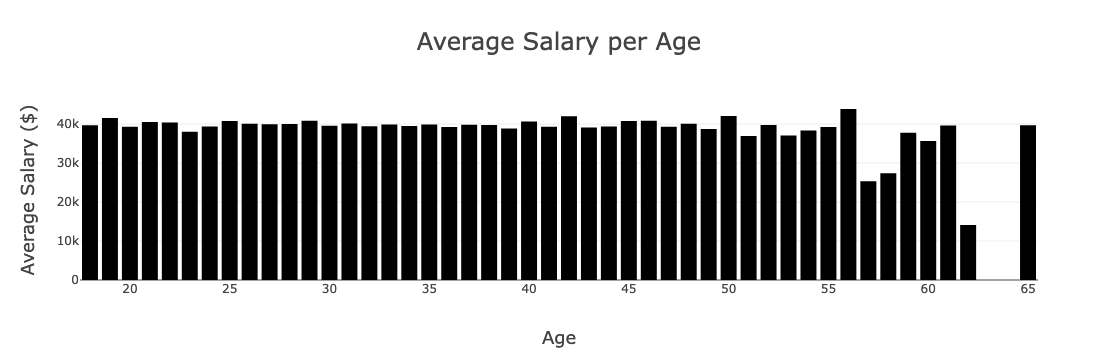

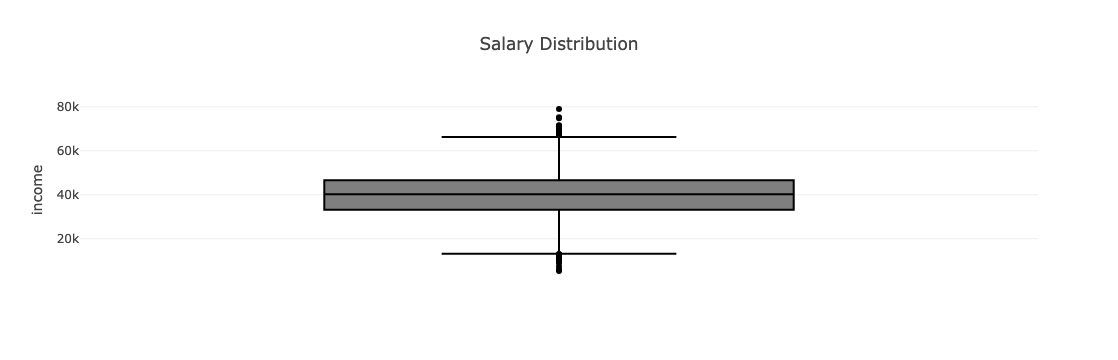

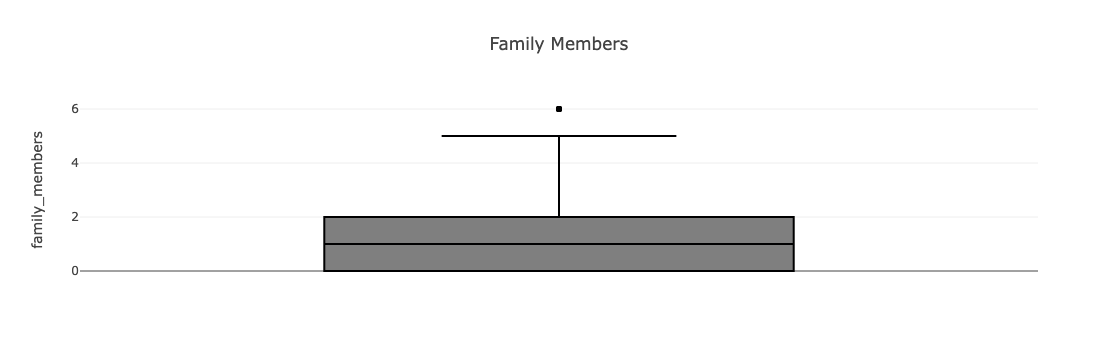

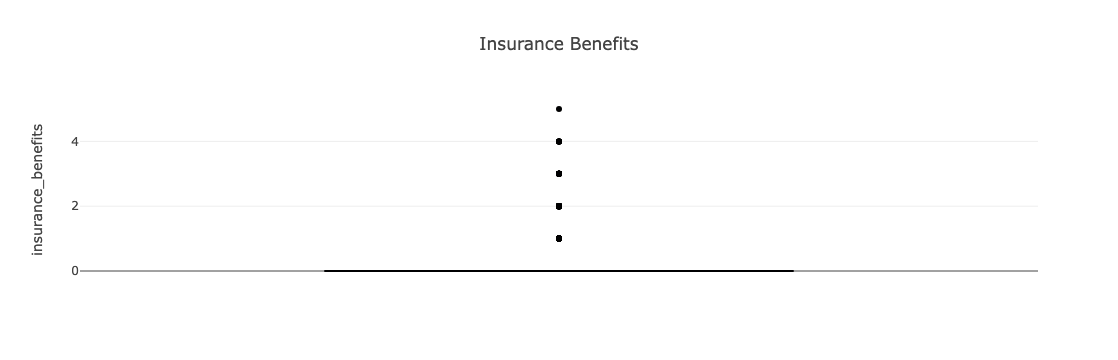

In [283]:
# Show all plots interactively
fig_bar.show()
fig_salary_box.show()
fig_family_members_box.show()
fig_insurance_benefits_box.show()

In [284]:
# Save all plots as static images for non-interactive environments
fig_bar.write_image("fig_bar.png")
fig_salary_box.write_image("fig_salary_box.png")
fig_family_members_box.write_image("fig_family_members_box.png")
fig_insurance_benefits_box.write_image("fig_insurance_benefits_box.png")

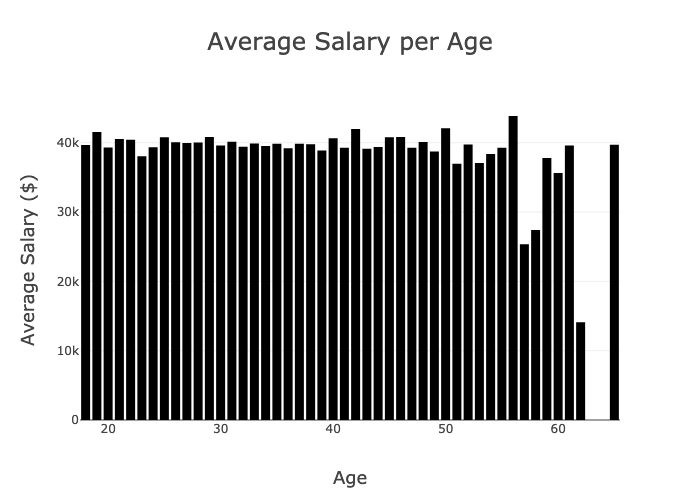

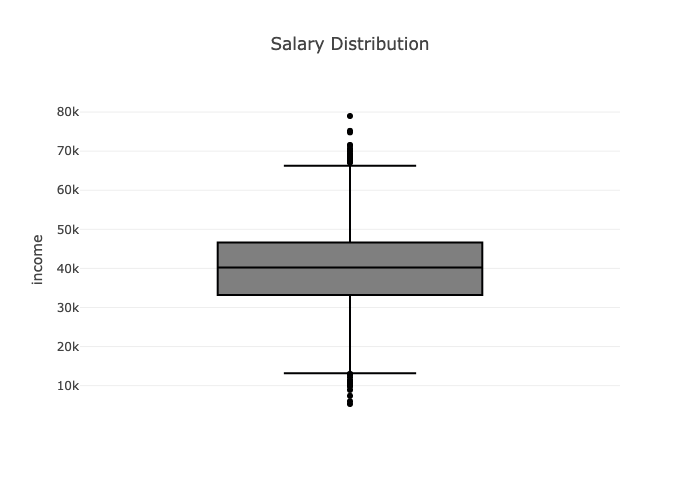

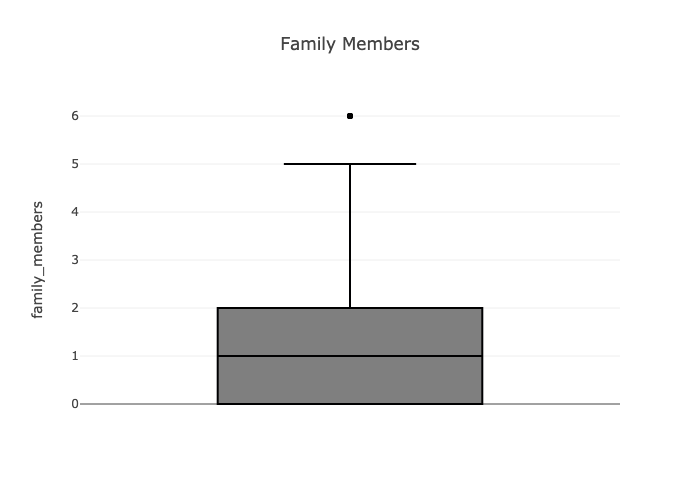

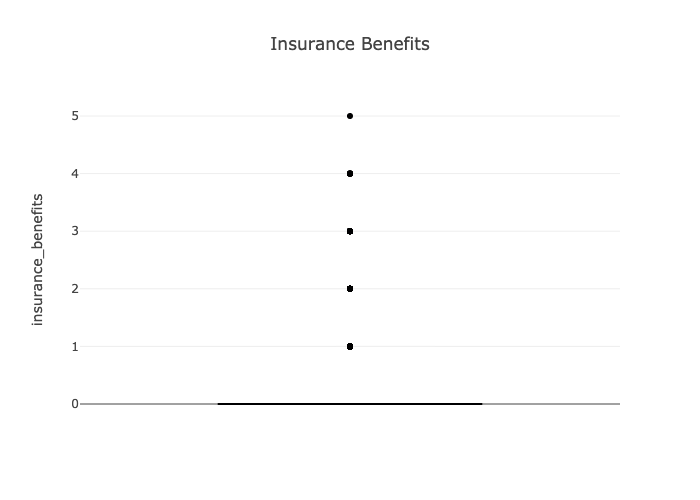

In [285]:
# Display static images
display(Image.open("fig_bar.png"))
display(Image.open("fig_salary_box.png"))
display(Image.open("fig_family_members_box.png"))
display(Image.open("fig_insurance_benefits_box.png"))

The data is pretty evenly dispersed for Age vs Salary, Age vs Num Family Members, and Age vs Gender, with a drop off in Salary, and also Num Family Members for the older ages. There seems to be a correlation between Age and Insurance Benefits. As Age goes up, so does Insurance Benefits. There is no data for ages 63 and 64.

- gender

In [288]:
def create_box_plot(y_column, y_label):
    fig = px.box(
        df,
        x='gender',
        y=y_column,
        title=f'{y_label} Distribution by Gender',
        labels={y_column: y_label, 'gender': 'Gender'}
    )
    fig.update_layout(
        title_font=dict(size=24), title_x=0.5,
        xaxis_title_font=dict(size=18),
        yaxis_title_font=dict(size=18)
    )
    return fig

In [289]:
# Create box plots
fig_salary_box = create_box_plot('income', 'Salary ($)')
fig_family_members_box = create_box_plot('family_members', 'Family Members')
fig_insurance_benefits_box = create_box_plot('insurance_benefits', 'Insurance Benefits')

In [290]:
# Save plots as images
fig_salary_box.write_image("fig_salary_box.png")
fig_family_members_box.write_image("fig_family_members_box.png")
fig_insurance_benefits_box.write_image("fig_insurance_benefits_box.png")

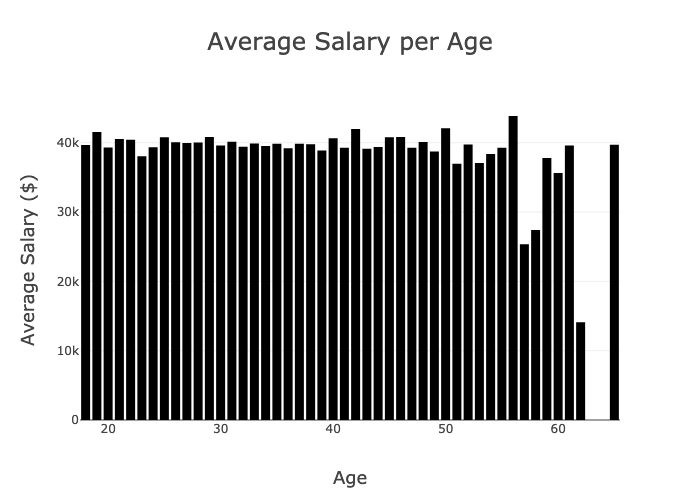

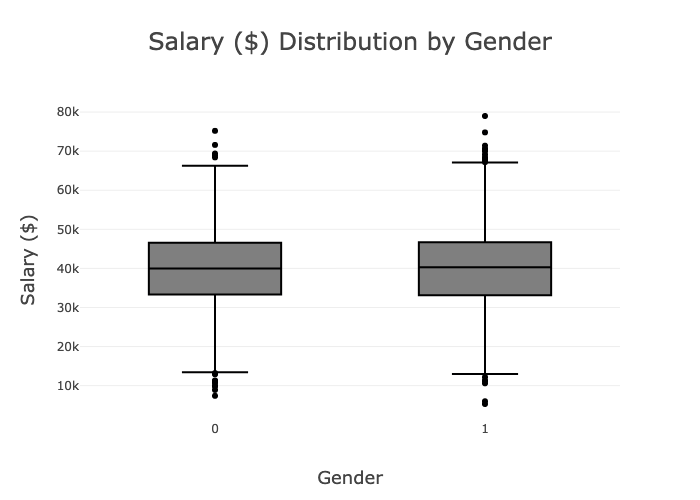

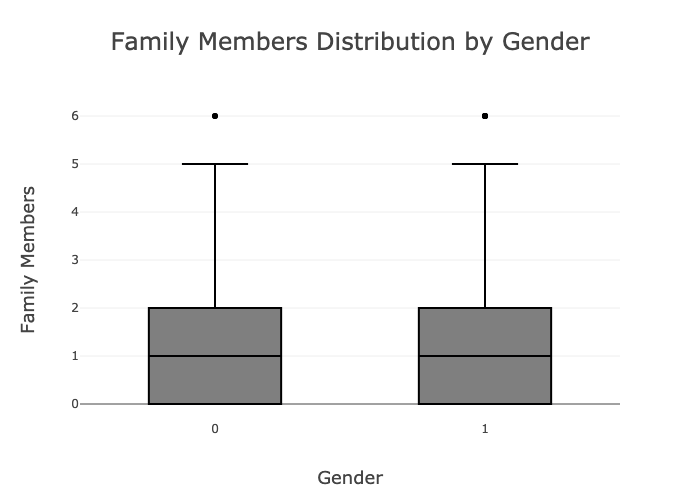

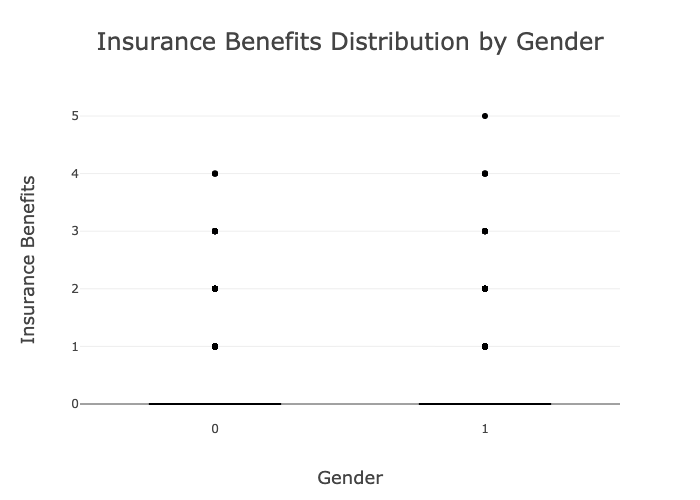

In [291]:
# Display static images
display(Image.open("fig_bar.png"))
display(Image.open("fig_salary_box.png"))
display(Image.open("fig_family_members_box.png"))
display(Image.open("fig_insurance_benefits_box.png"))

Data is pretty evenly dispersed for Gender vs Salary, and Gender vs Num Family Members. For Gender vs Insurance Benefits, males have more benefits. There are no females with more than 4 insurance benefits.

- income

In [294]:
def create_scatter_plot(x_column, y_column, x_label, y_label):
    fig = px.scatter(
        df,
        x=x_column,
        y=y_column,
        title=f'{y_label} vs {x_label}',
        labels={x_column: x_label, y_column: y_label}
    )
    fig.update_layout(
        title_font=dict(size=24), title_x=0.5,
        xaxis_title_font=dict(size=18),
        yaxis_title_font=dict(size=18)
    )
    return fig

In [295]:
# Create scatter plots
fig_family_salary = create_scatter_plot('family_members', 'income', 'Family Members', 'Income ($)')
fig_ins_benefits_salary = create_scatter_plot('insurance_benefits', 'income', 'Insurance Benefits', 'Income ($)')

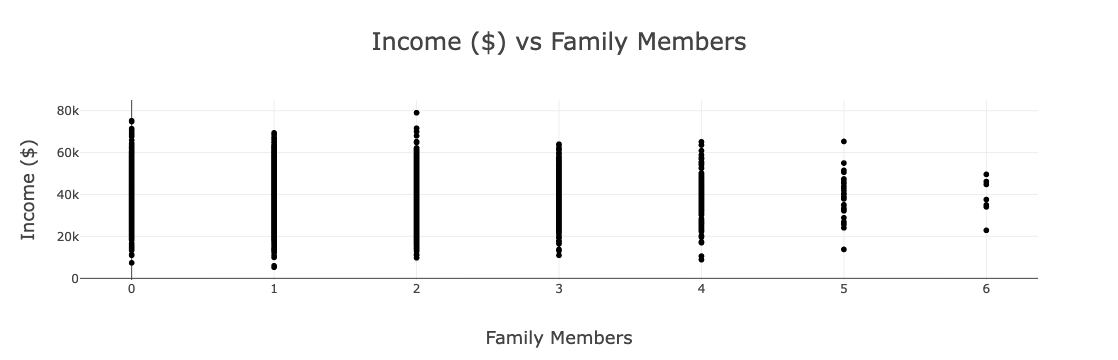

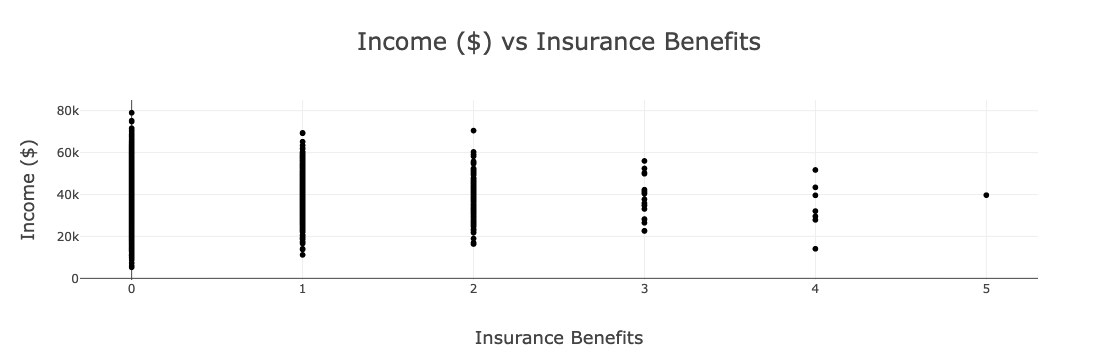

In [296]:
# Show plots
fig_family_salary.show()
fig_ins_benefits_salary.show()

There is not a big disparity between Salary and Num Family Members.  But, as Salary goes down, so does Num Family Members.  For Salary vs Insurance Benefits, there seems to be a correlation between these two. As salary goes down, so does Insurance Benefits.

- Family Members vs Insurance Benefits

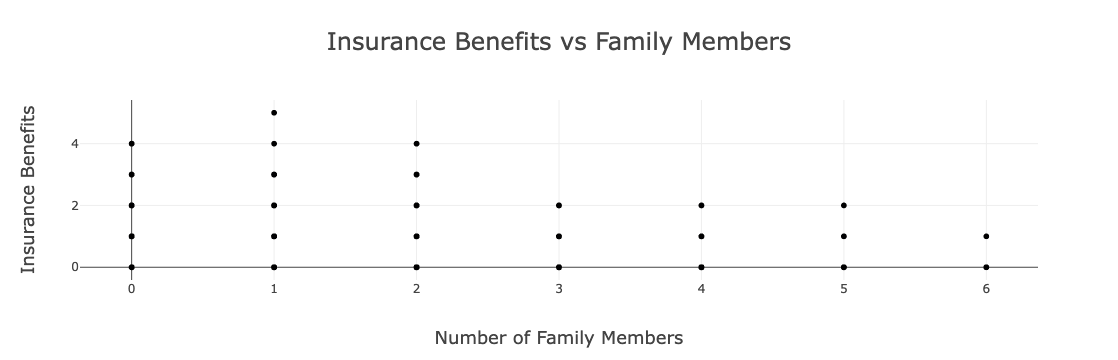

In [299]:
fig = px.scatter(
    df,
    x='family_members',
    y='insurance_benefits',
    title='Insurance Benefits vs Family Members',
    labels={'family_members': 'Number of Family Members', 'insurance_benefits': 'Insurance Benefits'},
)

# Customize the layout
fig.update_layout(
    title_font=dict(size=24), title_x=0.5,
    xaxis_title_font=dict(size=18),
    yaxis_title_font=dict(size=18)
)

fig.show()

As Insurance Benefits goes down, so do Number of Family Members. 

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [305]:
feature_names = ['gender', 'age', 'income', 'family_members']

- KNN

In [307]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names].to_numpy())
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

- Scaling the data.

In [309]:
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [310]:
df_scaled.sample(10)

,gender,age,income,family_members,insurance_benefits
4371,0,0.507692,0.510127,0.000000,0
1579,1,0.584615,0.669620,0.333333,0
4285,0,0.323077,0.481013,0.000000,0
2168,1,0.369231,0.321519,0.000000,0
284,1,0.353846,0.641772,0.000000,0
4324,1,0.430769,0.418987,0.000000,0
917,0,0.369231,0.446835,0.333333,0
3377,0,0.492308,0.141772,0.333333,0
3072,0,0.353846,0.349367,0.333333,0
2366,0,0.276923,0.683544,0.000000,0


Now, let's get similar records for a given one for every combination

- KNN: Scaled dataset - Euclidean Distance

In [313]:
#Call the KNN. The target is the 11th row.
print('Scaled dataset - Euclidean Distance')
print(get_knn(df_scaled, 10, 12, 'euclidean'))

Scaled dataset - Euclidean Distance
      gender       age    income  family_members  insurance_benefits  distance
10       1.0  0.384615  0.463291        0.166667                 0.0  0.000000
4377     1.0  0.384615  0.473418        0.166667                 0.0       NaN
1389     1.0  0.369231  0.464557        0.166667                 0.0       NaN
760      1.0  0.369231  0.462025        0.166667                 0.0       NaN
2254     1.0  0.400000  0.455696        0.166667                 0.0       NaN
3261     1.0  0.400000  0.473418        0.166667                 0.0       NaN
4201     1.0  0.400000  0.446835        0.166667                 0.0       NaN
4241     1.0  0.369231  0.446835        0.166667                 0.0       NaN
2609     1.0  0.400000  0.444304        0.166667                 0.0       NaN
26       1.0  0.384615  0.437975        0.166667                 0.0  0.025316
3444     1.0  0.369231  0.440506        0.166667                 0.0       NaN
491      1.0  0.

- KNN: Scaled Dataset - Manhattan Distance

In [315]:
#Call the KNN. The target is the 11th row.
print('Scaled dataset - Manhattan Distance')
display(get_knn(df_scaled, 10, 12, 'manhattan'))

Scaled dataset - Manhattan Distance


,gender,age,income,family_members,insurance_benefits,distance
10,1.0,0.384615,0.463291,0.166667,0.0,0.000000
4377,1.0,0.384615,0.473418,0.166667,0.0,NaN
1389,1.0,0.369231,0.464557,0.166667,0.0,NaN
760,1.0,0.369231,0.462025,0.166667,0.0,NaN
2254,1.0,0.400000,0.455696,0.166667,0.0,NaN
26,1.0,0.384615,0.437975,0.166667,0.0,0.025316
3261,1.0,0.400000,0.473418,0.166667,0.0,NaN
4201,1.0,0.400000,0.446835,0.166667,0.0,NaN
4241,1.0,0.369231,0.446835,0.166667,0.0,NaN
4128,1.0,0.384615,0.430380,0.166667,0.0,NaN


Most of the same neighbors appear in both the Eucidean and the Manhattan output.

- KNN: NOT scaled Dataset - Euclidean

In [318]:
df_not_scaled = df.copy()

In [319]:
# Visual checking for NaNs
print(df_not_scaled.isnull().sum().sort_values().tail())

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64


In [320]:
# Call the KNN function. The target is the 11th row.
knn_result_notScaled_euc = get_knn(df_not_scaled, 10, 12, 'euclidean')
print(knn_result_notScaled_euc)

      gender   age   income  family_members  insurance_benefits  distance
10       1.0  25.0  36600.0             1.0                 0.0  0.000000
4039     1.0  25.0  36600.0             2.0                 0.0       NaN
3247     1.0  26.0  36600.0             2.0                 0.0       NaN
2037     1.0  26.0  36600.0             0.0                 0.0       NaN
1949     0.0  24.0  36600.0             0.0                 0.0       NaN
1508     0.0  26.0  36600.0             0.0                 0.0       NaN
1573     0.0  27.0  36600.0             2.0                 0.0       NaN
2890     0.0  23.0  36600.0             0.0                 0.0       NaN
49       0.0  28.0  36600.0             1.0                 0.0  3.162278
4797     1.0  29.0  36600.0             2.0                 0.0       NaN
3060     0.0  20.0  36600.0             1.0                 0.0       NaN
3242     0.0  30.0  36600.0             1.0                 0.0       NaN
3924     NaN   NaN      NaN           

- KNN: NOT scaled - Manhattan

In [322]:
# Call the KNN function. The target is the 11th row.
knn_result_notScaled_manh = get_knn(df_not_scaled, 10, 12, 'manhattan')
print(knn_result_notScaled_manh)

      gender   age   income  family_members  insurance_benefits  distance
10       1.0  25.0  36600.0             1.0                 0.0       0.0
4039     1.0  25.0  36600.0             2.0                 0.0       NaN
2037     1.0  26.0  36600.0             0.0                 0.0       NaN
3247     1.0  26.0  36600.0             2.0                 0.0       NaN
1508     0.0  26.0  36600.0             0.0                 0.0       NaN
1949     0.0  24.0  36600.0             0.0                 0.0       NaN
2890     0.0  23.0  36600.0             0.0                 0.0       NaN
1573     0.0  27.0  36600.0             2.0                 0.0       NaN
49       0.0  28.0  36600.0             1.0                 0.0       4.0
4797     1.0  29.0  36600.0             2.0                 0.0       NaN
3242     0.0  30.0  36600.0             1.0                 0.0       NaN
3060     0.0  20.0  36600.0             1.0                 0.0       NaN
3924     NaN   NaN      NaN           

A lot of the same neighbors show up on both of the NOT scaled KNN output, for both Euclidean and Manhattan distances.

- Answers to the questions:

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, the scaled data has different outcomes, for the KNN algorithm,  than the non-scaled data.
- In the non-scaled data, most of the rows for Income were the same value. But the values for family_members was varied.
- in the scaled data, most of the rows for Income were varied. But the values for family_members was the same.

If one feature has a much larger range of values than others, it can disproportionately influence the calculation of distances. This can bias the KNN algorithm towards that feature, making others relatively insignificant.

KNN is a distance-based algorithm. When features are on different scales, features with larger ranges can dominate the distance calculations. This can lead to misleading results as the algorithm gives more weight to features with larger scales.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

- Manhattan ... using scaled data is less pronounced than with Euclidean distance. This is because Manhattan distance equally sums the absolute differences across all dimensions, which can sometimes make results more consistent across different scales.
- Eudlidean ... this calculates the straight-line distance between two points, giving more weight to larger differences. It is sensitive to feature scaling since it squares differences in each dimension.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [330]:
insurance_benefits_counts = df['insurance_benefits'].value_counts()
print(insurance_benefits_counts)

insurance_benefits
0    4284
1     423
2     114
3      18
4       7
5       1
Name: count, dtype: int64


There are 4284 value counts for 0. I want to exclude those.

In [332]:
(df['insurance_benefits'] > 0).sum()

563

In [333]:
# calculate the target. Add a new column to the database.
df['insurance_benefits_received'] = df['insurance_benefits'] > 0

In [334]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()

insurance_benefits_received
False    4284
True      563
Name: count, dtype: int64

- Evaluate classifier performance:

In [336]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    print('\n')
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

- Create dummy model:

In [338]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

- Evaluate dummy model probabilities:

This code gets run 4 times. 1=benefits received. 0=benefits NOT received.
First, the model predicts 0, so the F1 results in 0.
Next, the model makes predictions based on the actual customer data.
Thirdly, the model randomly predicts 1,  with a probability of 50%, so this model is more balanced.
Lastly, the model always predicts 1, so the f1 is 1.

In [341]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    
    #this calls the (Dummy Model) rnd_model_predict function...
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00


Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13


Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19


Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21


Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



Explanation of Confusion Matrix:
    
    Predicted Negative     Predicted Positive
    Actual Negative   [ TN                  FP ]
    Actual Positive   [ FN                  TP ]

- Split the data

In [344]:
# split the not-scaled data
X_train, X_test, y_train, y_test = train_test_split(df[feature_names],df['insurance_benefits_received'],test_size=.3,random_state=42)

In [345]:
# split the scaled data
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(df_scaled[feature_names],df['insurance_benefits_received'],test_size=.3,random_state=42)

In [346]:
# To store F1 scores for comparison
f1_scores_unscaled = []
f1_scores_scaled = []

- Sending NON SCALED data through the KNN function:

In [348]:
# Evaluate with NON scaled data
for k in range(1, 11):
    
    # create an instance of knn
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Send NOT scaled data
    knn.fit(X_train, y_train)
    
    #Make predictions
    y_pred = knn.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    f1_scores_unscaled.append(f1)
    print(f'k={k}, F1 (unscaled): {f1:.2f}')

k=1, F1 (unscaled): 0.66
k=2, F1 (unscaled): 0.47
k=3, F1 (unscaled): 0.45
k=4, F1 (unscaled): 0.16
k=5, F1 (unscaled): 0.17
k=6, F1 (unscaled): 0.08
k=7, F1 (unscaled): 0.10
k=8, F1 (unscaled): 0.03
k=9, F1 (unscaled): 0.04
k=10, F1 (unscaled): 0.03


- Sending SCALED data through the KNN function.

In [350]:
# Evaluate with scaled data
for k in range(1, 11):
    
    #Create an instance of KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Send scaled data this time
    knn.fit(X_train_scale, y_train_scale)
    
    #Make predictions
    y_pred = knn.predict(X_test_scale)
    
    f1 = f1_score(y_test_scale, y_pred)
    f1_scores_scaled.append(f1)
    print(f'k={k}, F1 (scaled): {f1:.2f}')

k=1, F1 (scaled): 0.95
k=2, F1 (scaled): 0.95
k=3, F1 (scaled): 0.95
k=4, F1 (scaled): 0.94
k=5, F1 (scaled): 0.95
k=6, F1 (scaled): 0.93
k=7, F1 (scaled): 0.96
k=8, F1 (scaled): 0.94
k=9, F1 (scaled): 0.94
k=10, F1 (scaled): 0.94


k ,  in KNN is a parameter that determines how many neighbors influence the prediction 

- Conclusion of F1 scores with scaled vs NON scaled data:

-- Non-Scaled Data: The F1 scores decrease significantly as the number of neighbors (k) increases. The F1 score starts at 0.66 for k=1 and drops as low as 0.02 for higher values of k. This indicates that the classifier performs poorly without scaling, particularly as more neighbors are considered.
    
-- Scaled Data: The best score is with k=7 ( 7 neighbors ). The F1 scores remain consistently high (around 0.93 to 0.96) across different values of k. This suggests that scaling the data greatly improves the classifier's performance
        
-- The initial F1 score for non-scaled data (0.66 for k=1) suggests reasonable performance, but it sharply declines with higher k values, indicating this approach is sensitive to changes in k.

-- The scaled data yields significantly better and more consistent results, compared to non-scaled data.

<b>Can a prediction model do better than a dummy model?</b>
Answer: Yes. A Prediction model can do better than a dummy model. This is evident from the significantly higher F1 scores for the KNN, with scaled data, compared to the dummy model.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated target (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [358]:
class MyLinearRegression:
    
    # Initializes the model with weights set to None
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adds a column of ones to X, to account for the intercept term.
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    #Uses the model's weights to make predictions on new data
    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [359]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print('\n')
    print(f'RMSE: {rmse:.2f}')
    print('\n')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [360]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)

#These weights are applied to each feature to make predictions:
print('\n')
print("Weights (Coefficients):", '\n', lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)



Weights (Coefficients): 
 [-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]


RMSE: 0.36


R2: 0.66


- <b>Weights</b>:

<b>Intercept (-9.77366729e-01):</b> This value represents the <b>expected value</b> of the insurance_benefits when all the features (age, gender, income, family_members) are zero.

<b>Coefficient for age (3.58042291e-02):</b>This coefficient means that for each unit increase in age, the insurance_benefits is expected to increase by approximately 0.0358 units, assuming other features remain constant.  Age seems to have a relatively more substantial impact, on insurance claims, than the other features. 

<b>Coefficient for gender (1.95594888e-02):</b>This coefficient implies that when gender increases by one unit, insurance_benefits is expected to increase by approximately 0.0196 units, assuming other features remain constant. 
    
<b>Coefficient for income (5.85336165e-07:</b>This very small coefficient suggests that the insurance_benefits changes very slightly with a unit change in income. This might indicate that income does not significantly influence insurance_benefits.
                           
<b>Coefficient for family_members (-1.21618420e-02):</b>This coefficient indicates that for each additional family member, insurance_benefits is expected to decrease by approximately 0.0122 units, assuming other features remain constant.
                           



<b>Reading coefficients:</b>

Positive sign (+): 
- Indicates a direct relationship with the target variable, meaning as the feature increases, so does the target.

Negative sign (−): 
- Indicates an inverse relationship with the target variable, meaning as the feature increases, the target decreases.


- <b>RMSE Score:</b>

The RMSE score is a measure of the average magnitude of the errors between the predicted and actual values:  <b>RMSE: 0.36</b>: This value shows the average difference between predicted and observed values.
        
- <b>R² Score</b> (The R² score ranges from 0 to 1.):
The R² score indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. 
Variance: Variance measures how much the values of a dataset are spread out from the mean.  <b>R²: 0.66</b>: This value indicates that 66% of the variance in insurance benefits can be attributed to differences in the features ('gender', 'age', 'income', 'family_members'). Generally, a higher R² indicates a better fit.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

- Data prep:

In [367]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']

#isolate those 4 features in to one dataframe
df_pn = df[personal_info_column_list]

In [368]:
#Create an array / matrix
X = df_pn.to_numpy()

- Generating a random matrix $P$.

In [370]:
#Use random number generator to create a square matrix.
#The number of rows and columns, in P, is determined by the number of columns in the array X.
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

- Checking if the matrix P is invertible:

In [372]:
det_P = np.linalg.det(P)

if det_P != 0:
    print("Matrix P is invertible.")
else:
    print("Matrix P is not invertible.")

Matrix P is invertible.


- Data Transformation (Obfuscation):

In [374]:
# Transforming the data. 
# @ is the operator used for matrix multiplication.
X_transformed = X @ P

- <b>Can you guess the customers' ages or income after the transformation?</b>

Answer: No. The transformation is designed to obscure specific values for privacy purposes, ensuring that sensitive information cannot be easily extracted from the transformed dataset.

- Recovery:

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [379]:
# Recovering the original data
P_inverse = np.linalg.inv(P)
X_recovered = X_transformed @ P_inverse

- Display Original, Transformed, and Recovered Data:

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [382]:
# Print original, transformed, and recovered data for a few customers
num_customers_to_show = 5  # Number of customers to showcase
for i in range(num_customers_to_show):
    print(f"Customer {i+1}")
    print("Original:  ", X[i])
    print("Transformed:", X_transformed[i])
    print("Recovered: ", X_recovered[i])
    print()

Customer 1
Original:   [1.00e+00 4.10e+01 4.96e+04 1.00e+00]
Transformed: [ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
Recovered:  [1.00e+00 4.10e+01 4.96e+04 1.00e+00]

Customer 2
Original:   [0.0e+00 4.6e+01 3.8e+04 1.0e+00]
Transformed: [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
Recovered:  [1.64503537e-12 4.60000000e+01 3.80000000e+04 1.00000000e+00]

Customer 3
Original:   [    0.    29. 21000.     0.]
Transformed: [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
Recovered:  [9.25561194e-13 2.90000000e+01 2.10000000e+04 1.41940791e-12]

Customer 4
Original:   [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
Transformed: [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
Recovered:  [-1.62563547e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]

Customer 5
Original:   [1.00e+00 2.80e+01 2.61e+04 0.00e+00]
Transformed: [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]
Recovered:  [1.00000000e+00 2.80000000e+01 2.6100000

Obfuscation: The transformation using ( \mathbf{P} ) changes the values such that features like age or income are no longer directly interpretable, ensuring privacy.

Recovery: By using the inverse of ( \mathbf{P} ), you can recover the original data exactly. This demonstrates that as long as ( \mathbf{P} ) is invertible, the transformation is perfectly reversible.

<b>You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?</b>

Answer: Operations like matrix multiplication and inversion involve floating-point arithmetic, where tiny errors accumulate, especially with large datasets.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

The obfuscation does not affect the model's prediction performance, maintaining the same RMSE.

**Analytical proof**

We need to examine how the weights ( w ) and ( w_P ) are related and how they affect predictions.
<br>
Recall that (X) is the original data matrix, and (P) is the obfuscation matrix.
<br>
$$
( \hat{y} )
$$
is the vector of predicted values. It is also known as y_pred.
<br>
<br>
<br>

<b>Original Weights and Predictions</b>
The weights (\( w \)) in linear regression are calculated using the formula:
$$
\[ w = (X^T X)^{-1} X^T y \]
$$
<br>
<br>

( X^T ) is the transpose of the matrix ( X ), which means the rows and columns of the matrix are swapped.
<br>
$$
( (X^T X)^{-1} )
$$ 
<br>
indicates the inverse of the matrix product ( X^T X ).
<br>
The inverse matrix is denoted by (superscript) -1. Example:
<span style="font-size: 24px;">A<sup>-1</sup></span>


<br>
<br>
$$
( X^T y )
$$
involves multiplying the transposed feature matrix ( X ) with the target vector ( y ).
<br>
<br>
<br>




<b>Predicted values are calculated as:</b>
$$
\[ \hat{y} = X w \]
$$
<br>
<br>
<br>



<b>Obfuscated Weights and Predictions</b>
After data obfuscation, the feature matrix is transformed to:
$$
\[ X' = X P \]
$$
where \( P \) is an invertible matrix.
<br>
<br>
<br> 
  
  
  
<b>The weights for the obfuscated data can be calculated as:</b>
$$
\[ w_P = [(X P)^T (X P)]^{-1} (X P)^T y \]
$$
<b>This simplifies to:</b>
$$
\[ w_P = P^{-1} w \]
$$
because the properties of invertible matrices allow us to factor \( P \) out.
<br>
<br>
<br>  
  
  
  
<b>Predicted Values</b>
The predicted values using the obfuscated weights are:
$$
\[ \hat{y_P} = (X P) w_P = X (P P^{-1}) w = X w = \hat{y} \]
$$
<br>
<br>
<br>  
  
  
  
<b>Impact on RMSE</b>
Since the predicted values remain unchanged, the RMSE (Root Mean Square Error) also stays the same:
$$
\[ \text{RMSE}_P = \text{RMSE} \]
$$
<br>
<br>
<br>  
  
  
  
  
This shows that the obfuscation does not affect the model's prediction performance, maintaining the same RMSE.


## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- If it is zero, repeat the process; otherwise, return the matrix ( P ).
- Use $XP$ as the new feature matrix

In [396]:
# Create a matrix filled with 0s and 1s.
def generate_invertible_matrix(size):
    """
    Generates an invertible (non-singular) matrix of a given size.
    The matrix is generated randomly using numpy.
    Args:
        size (int): The size of the matrix (n x n).
    Returns:
        np.ndarray: An invertible matrix of shape (size, size).
    """
    while True:
        matrix = np.random.rand(size, size)
        
        #Check to see if the matrix is invertible
        if np.linalg.matrix_rank(matrix) == size:
            return matrix

In [397]:
# evaluate predictions
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

In [398]:
# Function to evaluate with obfuscation
def linear_regression_with_obfuscation(X_train, y_train, X_test, y_test, obfuscate=False):
    # Check to see if it should be obfuscated
    if obfuscate:
        P = generate_invertible_matrix(X_train.shape[1])
        # Obfuscate the features
        X_train = X_train @ P
        # Also obfuscate the test data for consistency
        X_test = X_test @ P  
        
    # Fit Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    return y_pred, rmse, r2

In [399]:
# Create and fit a linear regression model on the original data
original_model = LinearRegression()
original_model.fit(X_train, y_train)

# Assuming X_train, X_test, y_train, y_test are defined
original_pred = original_model.predict(X_test)
original_rmse = mean_squared_error(y_test, original_pred, squared=False)
original_r2 = r2_score(y_test, original_pred)

In [400]:
obfuscated_pred, obfuscated_rmse, obfuscated_r2 = linear_regression_with_obfuscation(X_train, y_train, X_test, y_test, obfuscate=True)

In [401]:
# Print comparisons
print("Original RMSE:", original_rmse)
print("Original R^2:", original_r2)
print("Obfuscated RMSE:", obfuscated_rmse)
print("Obfuscated R^2:", obfuscated_r2)

Original RMSE: 0.3601751175025617
Original R^2: 0.4328755262191816
Obfuscated RMSE: 0.3601751175026252
Obfuscated R^2: 0.4328755262189814


The original_rmse (Root Mean Square Error) and obfuscated_rmse values are very close, indicating that the obfuscation process does not significantly impact the error of the model's predictions.
Similarly, original_r2 (R-squared) and obfuscated_r2 are quite similar, suggesting that the obfuscation has little to no effect on the proportion of variance explained by the model.

In [403]:
#Evaluate difference in predictions
prediction_difference = np.linalg.norm(original_pred - obfuscated_pred)
print("Difference between predictions (norm):", prediction_difference)

Difference between predictions (norm): 1.944137527915682e-10


That is a tiny number, very close to zero. There is almost no difference, in a Linear Regression model, for obfuscated vs original data.

## Conclusion:

I analyzed the dataset for "The Sure Tomorrow" insurance company, seeking to find the answers to these 4 questions:

<b>Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.</b>

I used Euclidean and. Manhattan Metrics to find similiar customers.

Both metrics identified many of the same nearest neighbors, particularly in cases where the data is scaled. This suggests that while scaling can have different effects on each method, certain inherent data relationships remain consistent.

Manhattan distance tends to be more robust to features being on different scales because it considers all feature differences linearly, making results from scaled and unscaled data more similar compared to Euclidean.

Scaling data plays a crucial role in ensuring fair contribution of all features to the distance metric, especially for Euclidean distance.

<b>Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?</b>

In this analysis, I compared a KNN-based classifier against a dummy model to evaluate the likelihood of customers receiving insurance benefits. 

Non-Scaled Data: The KNN classifier, when applied to non-scaled data, performed poorly, with F1 scores declining from 0.66 at k=1 to as low as 0.02 for higher values.

Scaled Data: Scaling greatly enhanced the KNN's performance, maintaining high F1 scores between 0.93 and 0.96 across various k values. 

The dummy model, which predicts randomly based on fixed probabilities, exhibited a significantly lower predictive performance compared to the KNN classifier. This is evident from the consistently higher F1 scores of the KNN model on scaled data.

The scaled KNN classifier outperformed the dummy model.


<b>Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.</b>

The Linear Regression model, implemented through matrix algebra, to predict insurance_benefits, provides insightful results on both the feature influence and prediction accuracy.

Firstly, examining the feature coefficients offers a glimpse into how each attribute impacts the target variable:

Age: The positive coefficient (0.0358) suggests that age has the most significant direct impact on insurance_benefits. This implies that as a person's age increases, the expected insurance benefits also increase, assuming other factors remain constant.

<b>Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.</b>

The obfuscation maintains the model's performance and secures personal data. 

RMSE and R^2 values for both the original, and obfuscated datasets, are almost identical. It implies that the obfuscation process does not significantly degrade the model's performance. 

The primary objective of this project was to assess the impact of data obfuscation on the performance of a linear regression model. By employing an invertible matrix to obfuscate the feature set while maintaining data integrity, we sought to secure sensitive input features without compromising predictive accuracy.

In conclusion, this project highlights the efficacy of using invertible matrix transformations for data obfuscation in machine learning contexts. Such methodologies can effectively safeguard feature data, ensuring privacy and security, while preserving model accuracy and interpretability. Future explorations could expand on this work by applying similar obfuscation techniques to other machine learning algorithms, examining the scalability of these methods in varied data environments.

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>